# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Table of Contents
<ul>
    <li><a href="#intro">Library import</a></li>
    <li><a href="#exploration">Part 0: Get to know the Data</a></li>
    <li><a href="#content">Part 0.1: Content and column evaluation</a></li>
    <li><a href="#nans"> Part 0.2: Missing values</a></li>
    <li><a href="#data_cleaning">Part 0.3: Data cleaning</a></li>
    <li><a href="#data_prep">Part 0.4: Data preparation for machine learning</a></li>
    <li><a href="#report">Part 1: Customer Segmentation Report</a></li>
    <li><a href="#pca">Part 1.1: Feature selection</a></li>
    <li><a href="#kmean">Part 1.2: KMean Clustering</a></li>
    <li><a href="#model">Part 2: Unsupervised Model</a></li>
    <li><a href="#lin_reg">Part 2.1: Logistic regression Model</a></li>
    <li><a href="#dc">Part 2.2: Decision Tree Model</a></li>
    <li><a href="#rfc">Part 2.3: RFC Model</a></li>
    <li><a href="#gbc">Part 2.4: Gradient Boost Model</a></li>
    <li><a href="#gridsearch">Part 2.3: GridSearch Optimization</a></li>
    <li><a href="#kaeggle">Part 3: Kaeggle Competition</a></li>
</ul>

<a id='intro'></a>
### Import of all relevant libraries

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn import datasets
from sklearn.datasets import *
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import time

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<a id='exploration'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
azdias.shape

(891221, 367)

In [4]:
customers.shape

(191652, 370)

<a id='content'></a>
### Part 0.1 Content and column evaluation

In this part, I will focus on the datatypes and content to find out the reason for the dtype warning and measures to correct it.

In [5]:
def show_types_nans(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    df_types - (pandas dataframe) dataframe with details about df columns, column types and the sum of NaNs in this column.
    
    '''
    cols = []
    types = []
    nans = []
    n = len(df.columns)
    for i in range(0, n):
        cols.append(df.columns[i])
        types.append(df[df.columns[i]].dtype)
        nans.append(sum(df[df.columns[i]].isna()))

    df_types = pd.DataFrame({'column_name': cols,
                            'd_types': types,
                            '#_nans': nans}) 
    df_types['perc_nans'] = df_types['#_nans']/len(df)
    return df_types

In [6]:
df_types_customer = show_types_nans(customers)
df_types_customer.head()

,column_name,d_types,#_nans,perc_nans
0,Unnamed: 0,int64,0,0.000000
1,LNR,int64,0,0.000000
2,AGER_TYP,int64,0,0.000000
3,AKT_DAT_KL,float64,46596,0.243128
4,ALTER_HH,float64,46596,0.243128


In [7]:
df_types_customer['d_types'].value_counts()

float64    267
int64       95
object       8
Name: d_types, dtype: int64

In [8]:
df_types_customer[df_types_customer['d_types'] == object]

,column_name,d_types,#_nans,perc_nans
18,CAMEO_DEU_2015,object,50428,0.263123
19,CAMEO_DEUG_2015,object,50428,0.263123
20,CAMEO_INTL_2015,object,50428,0.263123
62,D19_LETZTER_KAUF_BRANCHE,object,47697,0.248873
98,EINGEFUEGT_AM,object,49927,0.260509
318,OST_WEST_KZ,object,49927,0.260509
365,PRODUCT_GROUP,object,0,0.000000
366,CUSTOMER_GROUP,object,0,0.000000


> First, I will have a closer look at all string columns as they are not suitable for machine learning algorithms.

In [9]:
customers['CAMEO_DEU_2015'].value_counts()

2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

> The column "CAMEO_DEU_2015" is a string indeed with combinations of numbers and letters. The value "XX" is not part of the value overview list and will therefore be replaced by np.nan.

In [10]:
customers['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

> The column CAMEO_DEUG_2015 should be an integer or float so there won't be a misinterpretation due to the separation of 9 and 9.0 (as example). The value "X" is not part of the value overview list.

In [11]:
customers['CAMEO_INTL_2015'].value_counts()

14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

> The columns 'CAMEO_INTL_2015' has the same problem as the column 'CAMEO_DEUG_2015'. Both contain floats, integers and strings (value: XX or X). The value XX is not in the value list provided by the overview sheet. It is assumed that the records with value XX have an unknown entry and will be therefore changed to np.nan.

In [12]:
customers['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_REST           3619
D19_BANKEN_DIREKT          3466
D19_LEBENSMITTEL           3053
D19_TELKO_REST             2303
D19_NAHRUNGSERGAENZUNG     2253
D19_TELKO_MOBILE           2131
D19_TECHNIK                1836
D19_BANKEN_GROSS           1684
D19_FREIZEIT               1672
D19_SAMMELARTIKEL          1610
D19_RATGEBER               1519
D19_KINDERARTIKEL          1439
D19_WEIN_FEINKOST          1424
D19_BANKEN_REST            1233
D19_BIO_OEKO                808
D19_REISEN                  666
D19_DIGIT_SERV              653
D19_GARTEN                  568
D19_HANDWERK                532
D19_BILDUNG                 357
D19_TIER

> The column "D19_LETZTER_KAUF_BRANCHE" contains indeed strings and has the string "D19_UNBEKANNT" as a remark for "unknown". As this string will not be used in the Machine learning model, NaNs will be replaced by "D19_UNBEKANNT".

In [13]:
customers['EINGEFUEGT_AM'].value_counts()

1992-02-10 00:00:00    64744
1992-02-12 00:00:00    43686
2003-11-18 00:00:00     1066
2005-12-16 00:00:00      808
1995-02-07 00:00:00      569
2004-04-14 00:00:00      443
2005-08-23 00:00:00      391
2005-04-15 00:00:00      363
1993-03-01 00:00:00      357
1995-10-10 00:00:00      317
2000-05-10 00:00:00      315
1992-02-21 00:00:00      304
1993-09-21 00:00:00      294
1993-10-21 00:00:00      287
1993-09-22 00:00:00      231
1995-07-19 00:00:00      209
2005-04-12 00:00:00      200
1993-11-03 00:00:00      193
1995-08-02 00:00:00      189
1996-01-26 00:00:00      187
1993-11-02 00:00:00      181
1995-08-15 00:00:00      180
1995-10-17 00:00:00      179
1993-09-23 00:00:00      177
1993-01-20 00:00:00      166
1993-03-23 00:00:00      159
1993-10-25 00:00:00      152
1995-12-27 00:00:00      149
1995-09-06 00:00:00      148
2004-10-14 00:00:00      147
2006-01-19 00:00:00      143
1996-03-04 00:00:00      133
1996-02-29 00:00:00      132
1995-10-18 00:00:00      128
1993-09-28 00:

In [14]:
sum(customers['EINGEFUEGT_AM'].isna())

49927

> The column "EINGEFUEGT_AM" is currently a string but contains only datetimes. Therefore, it will be converted to Datetime.

In [15]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

> The column "OST_WEST_KZ" has only two values (W for West and O for East) and can therefore be encrypted to 1-0 before using the column in Machine learning.

In [16]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [17]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

> The columns "PRODUCT_GROUP" and "CUSTOMER_GROUP" are only available in the customers dataset and cannot be used to find similarities between the customers group and the general population of germany. Therefore, they will not be encrypted and remain strings for now.

<a id='nans'></a>
### Part 0.2: Missing values
In this part, I will focus on the missing values in the datasets to evalate what rows and columns to keep for further analysis.

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/2815391771.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show();


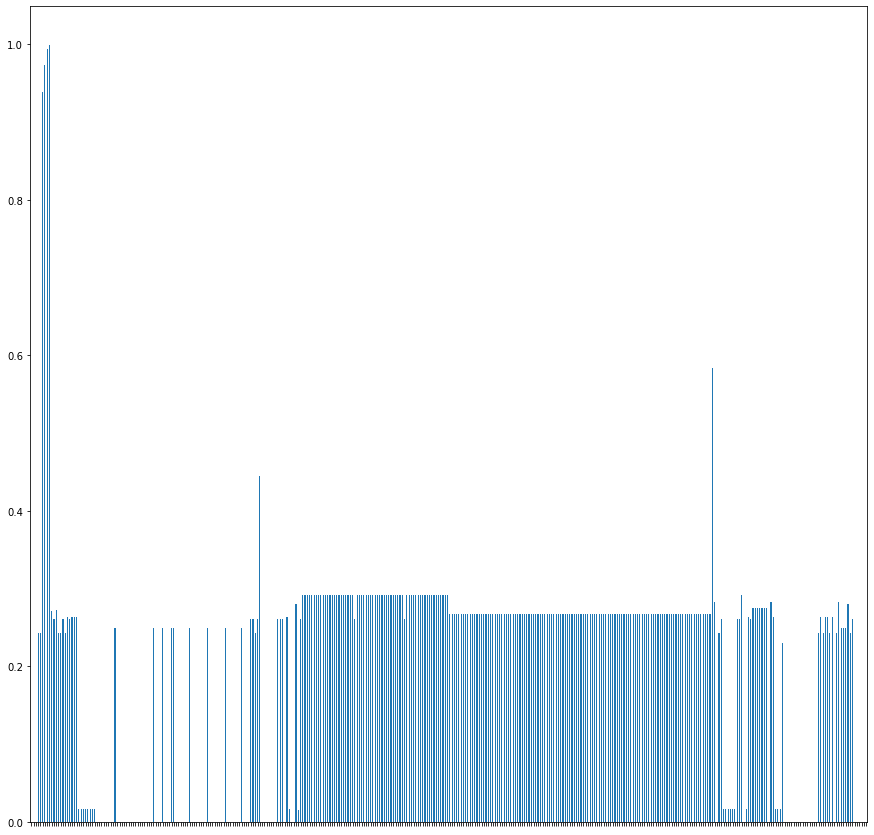

In [18]:
subplot = df_types_customer['perc_nans'].plot.bar(figsize=(15,15))
ax = subplot.axes
ax.set_xticklabels([])
f = ax.get_figure()
f.show();

> There are a few columns with a lot of missing values in the customer dataframe. All columns with more than 30% of missing values will be evaluated.

In [19]:
df_types_customer[df_types_customer['perc_nans'] >0.3]

,column_name,d_types,#_nans,perc_nans
5,ALTER_KIND1,float64,179886,0.938607
6,ALTER_KIND2,float64,186552,0.973389
7,ALTER_KIND3,float64,190377,0.993347
8,ALTER_KIND4,float64,191416,0.998769
101,EXTSEL992,float64,85283,0.444989
301,KK_KUNDENTYP,float64,111937,0.584064


In [20]:
df_types_azdias = show_types_nans(azdias)

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/1485993310.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show();


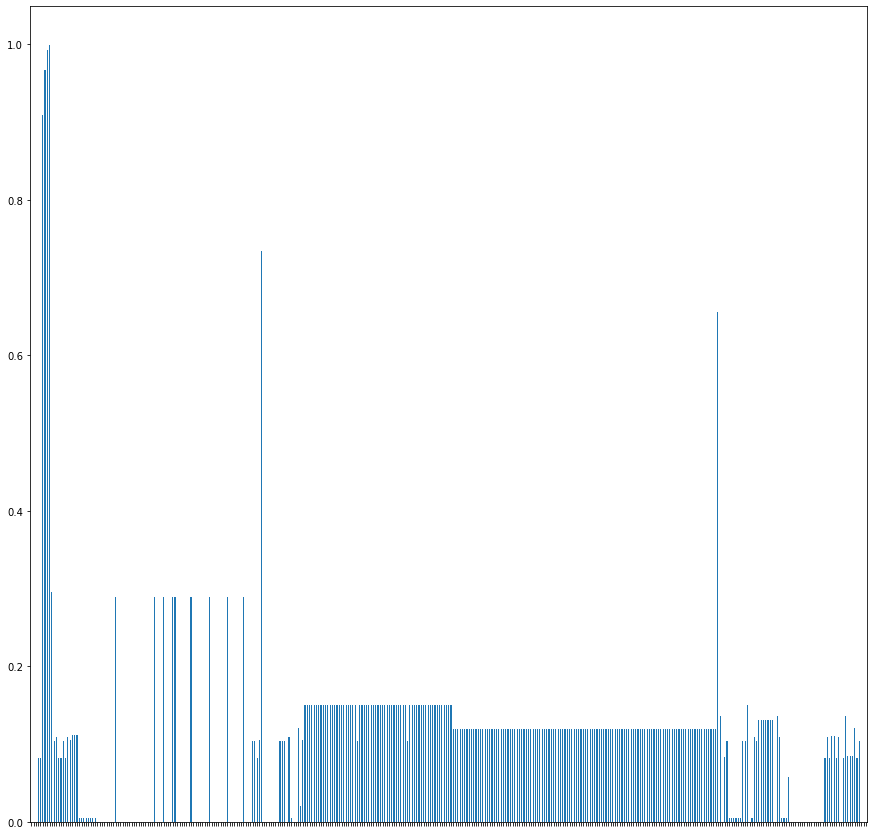

In [21]:
subplot = df_types_azdias['perc_nans'].plot.bar(figsize=(15,15))
ax = subplot.axes
ax.set_xticklabels([])
f = ax.get_figure()
f.show();

In [22]:
df_types_azdias[df_types_azdias['perc_nans'] >0.3]

,column_name,d_types,#_nans,perc_nans
5,ALTER_KIND1,float64,810163,0.909048
6,ALTER_KIND2,float64,861722,0.966900
7,ALTER_KIND3,float64,885051,0.993077
8,ALTER_KIND4,float64,890016,0.998648
101,EXTSEL992,float64,654153,0.733996
301,KK_KUNDENTYP,float64,584612,0.655967


> The columns with more than 30% of missing values are similar in the azdias and customers dataset. Therfore, all columns above the missing value threshold of 30% will be deleted. 
> Next, the dataset will be analysed according to missing rows.

In [23]:
def plot_missing_row(df1, df2, bins=30, figsize=(15,15)):
    '''
    INPUT:
    df1 - (pandas dataframe) df as defined at the top of the notebook
    df2 - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    Plot showing the count of rows according to the percentage of missing features
    
    '''
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title('Occurance of missing features count in rows')
    ax.set_xlabel('Number of Missing features')
    ax.set_ylabel('Row count')
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


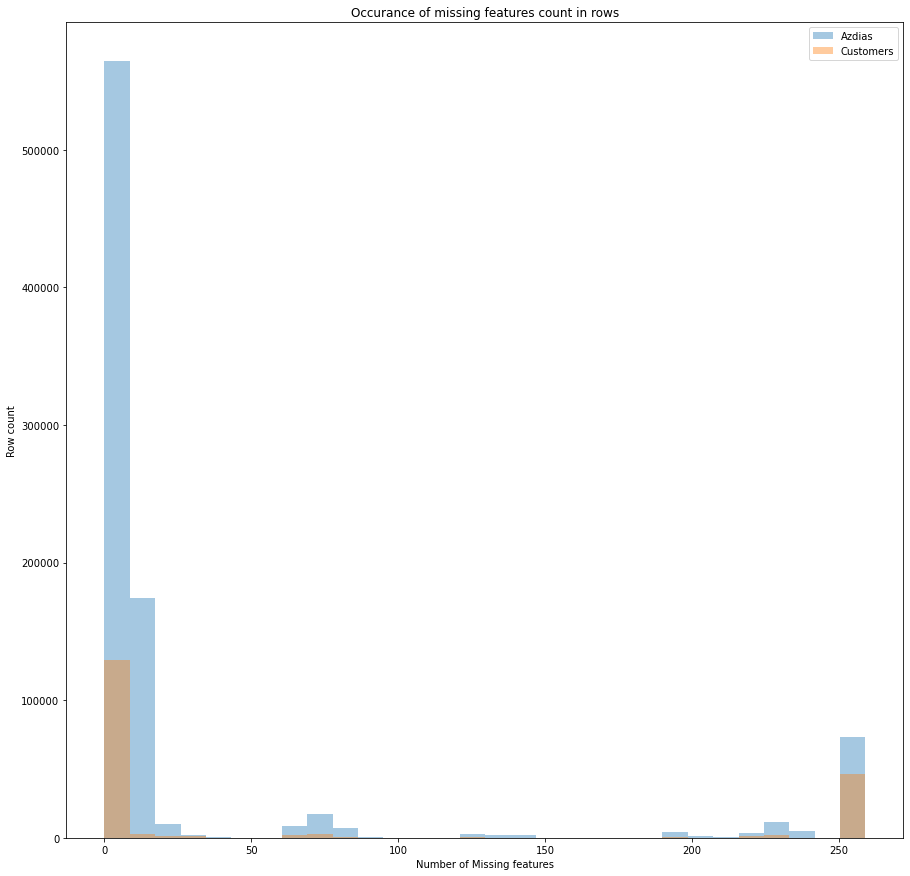

In [24]:
plot_missing_row(azdias, customers)

> Most rows have only a few missing features. To reduce the dataset and raise the quality of the analysis, all rows with more than 50 missing features will be dropped.

In [25]:
def remove_missing_rows(df, threshold):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
      
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df, removed_rows

In [26]:
customers_test, removed_rows_cust = remove_missing_rows(customers, threshold=50)
azdias_test, removed_rows_azd = remove_missing_rows(azdias, threshold = 50)

In [27]:
azdias_test.shape

(751331, 367)

In [28]:
azdias.shape

(891221, 367)

In [29]:
removed_rows_azd

139890

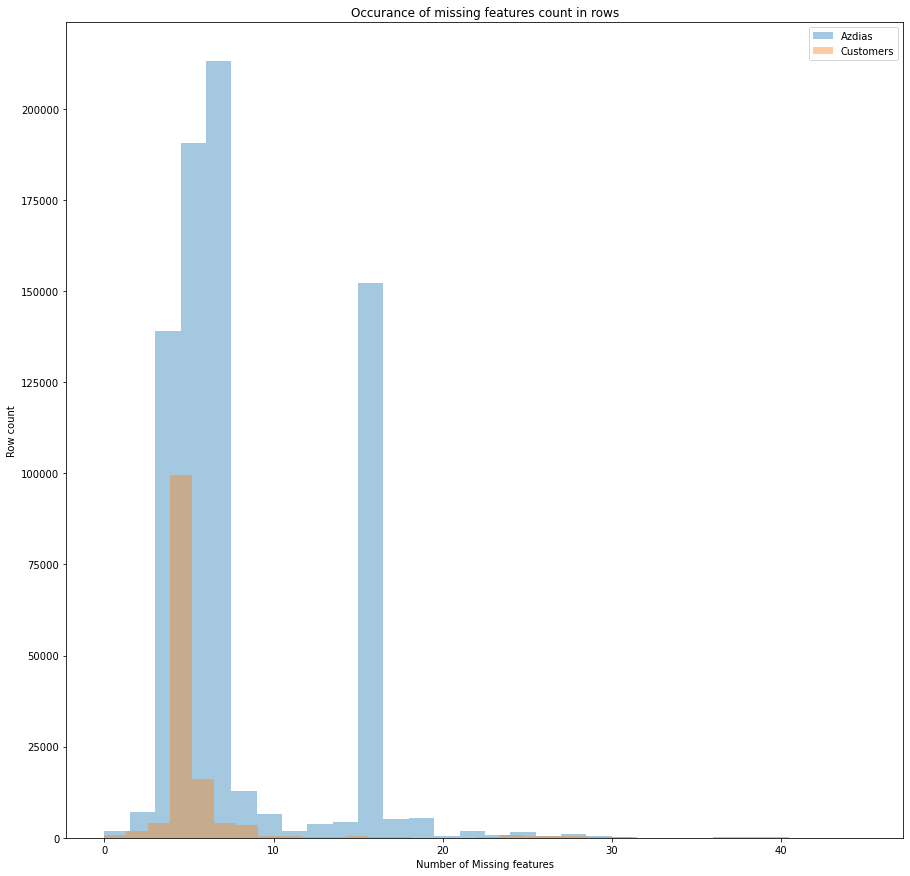

In [30]:
plot_missing_row(azdias_test, customers_test)

<a id='data_cleaning'></a>
### Part 0.3: Cleaning the Dataset
In order to skip Part 0 in the further process, all definitions in Part 0 will be shown here again and a full cleaning pipeline will be created.

In [31]:
def show_types_nans(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    df_types - (pandas dataframe) dataframe with details about df columns, column types and the sum of NaNs in this column.
    
    '''
    cols = []
    types = []
    nans = []
    n = len(df.columns)
    for i in range(0, n):
        cols.append(df.columns[i])
        types.append(df[df.columns[i]].dtype)
        nans.append(sum(df[df.columns[i]].isna()))

    df_types = pd.DataFrame({'column_name': cols,
                            'd_types': types,
                            '#_nans': nans}) 
    df_types['perc_nans'] = df_types['#_nans']/len(df)
    return df_types

def plot_missing_row(df1, df2, bins=30, figsize=(15,15)):
    '''
    INPUT:
    df1 - (pandas dataframe) df as defined at the top of the notebook
    df2 - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    Plot showing the count of rows according to the percentage of missing features
    
    '''
    bins = 30
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title('Occurance of missing features count in rows')
    ax.set_xlabel('Number of Missing features')
    ax.set_ylabel('Row count')
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
    ax.legend()
    
    plt.show()
    
def remove_missing_rows(df, threshold):
    """
    Takes in a dataframe and drops rows with number of missing features 
    as per given threshold.
    """
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
      
    # Reset index
    df = df.reset_index()
    del df['index']
    
    return df, removed_rows

In [32]:
def data_load_and_clean(path):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    full_df - (pandas dataframe) cleaned dataframe where unknown values and X/XX were replaced by np.nan according to the
        azdias information. All numeric columns have been cleaned and converted to integers.
    
    '''
    df_new = pd.read_csv(path)
    
    print("Filling NaNs...")
    #replace "unknown" and values not in value overview with np.nan
    df_new['CAMEO_INTL_2015'].replace({'XX': np.nan, -1:np.nan}, inplace=True)
    df_new['CAMEO_DEU_2015'].replace({'XX': np.nan, -1:np.nan}, inplace=True)
    df_new['CAMEO_DEUG_2015'].replace({'X': np.nan, -1:np.nan}, inplace=True)
    df_new['ALTER_HH'].replace(0, np.nan, inplace = True)
    df_new['CJT_GESAMTTYP'].replace(0, np.nan, inplace =True)
    df_new['RETOURTYP_BK_S'].replace(0, np.nan, inplace = True)
    if 'D19_LETZTER_KAUF_BRANCHE' in df_new.columns:
        df_new['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT', inplace = True)
    df_new['EINGEFUEGT_AM'] = pd.to_datetime(df_new['EINGEFUEGT_AM'], errors = 'coerce')
    df_new.replace(-1, np.nan, inplace = True)
    
    print("Splitting of CAMEO_INTL_2015 into _WEALTH and _FAMILY...")
    #split CAMEO_INTL_2015 into wealth and family and drop original column
    df_new['CAMEO_INTL_2015_WEALTH'] = df_new['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) 
                                                                       if float(x) else np.nan)
    df_new['CAMEO_INTL_2015_FAMILY'] = df_new['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    df_new.drop(columns = 'CAMEO_INTL_2015', inplace = True)
    
    print("Dropping columns with more than 30% NaN's...")
    #drop columns with more than 30% NaN's
    df_types = show_types_nans(df_new)
    col_drop = df_types[df_types['perc_nans'] > 0.3]
    df_new.drop(columns = col_drop['column_name'], inplace = True)
    print("Dropped columns: /n{}".format(col_drop['column_name']))
    
    print("Dropping columns with more than 50 missing features...")
    #drop rows with more than 50 missing features
    df_new, removed_rows = remove_missing_rows(df_new, threshold = 50)
    print("Total rows removed: {}".format(removed_rows))
    
    print("Correcting dtypes...")
    #correct types
    cols_obj = df_types[df_types['d_types'] == object]
    cols_obj_list = list(cols_obj['column_name'])
    cols_obj_list.insert(0,'EINGEFUEGT_AM')
    df_no_numeric = df_new.loc[:, df_new.columns.isin(cols_obj_list)]
    df_numeric = df_new.copy().drop(columns = df_no_numeric.columns)
    df_numeric = df_numeric.astype('Int64', errors='ignore')
    full_df = pd.concat([df_no_numeric, df_numeric], axis = 1)
    
    print("Finished: Dataset loaded and cleaned!")
    return full_df
    

> Due to the initial load as a part of the function, the warning will still appear but cleaned right away.

In [33]:
azdias_clean = data_load_and_clean('Udacity_AZDIAS_052018.csv')

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/326745743.py:1: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  azdias_clean = data_load_and_clean('Udacity_AZDIAS_052018.csv')


Filling NaNs...
Splitting of CAMEO_INTL_2015 into _WEALTH and _FAMILY...
Dropping columns with more than 30% NaN's...
Dropped columns: /n2          AGER_TYP
4          ALTER_HH
5       ALTER_KIND1
6       ALTER_KIND2
7       ALTER_KIND3
8       ALTER_KIND4
100       EXTSEL992
300    KK_KUNDENTYP
Name: column_name, dtype: object
Dropping columns with more than 50 missing features...
Total rows removed: 139890
Correcting dtypes...
Finished: Dataset loaded and cleaned!


In [34]:
customers_clean = data_load_and_clean('Udacity_CUSTOMERS_052018.csv')

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/3618105397.py:1: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  customers_clean = data_load_and_clean('Udacity_CUSTOMERS_052018.csv')


Filling NaNs...
Splitting of CAMEO_INTL_2015 into _WEALTH and _FAMILY...
Dropping columns with more than 30% NaN's...
Dropped columns: /n2          AGER_TYP
4          ALTER_HH
5       ALTER_KIND1
6       ALTER_KIND2
7       ALTER_KIND3
8       ALTER_KIND4
100       EXTSEL992
300    KK_KUNDENTYP
Name: column_name, dtype: object
Dropping columns with more than 50 missing features...
Total rows removed: 56508
Correcting dtypes...
Finished: Dataset loaded and cleaned!


In [35]:
azdias_clean.shape

(751331, 360)

In [36]:
df_types_clean = show_types_nans(azdias_clean)
df_types_clean['d_types'].value_counts()

Int64             355
object              4
datetime64[ns]      1
Name: d_types, dtype: int64

In [37]:
customers_clean.shape

(135144, 363)

In [38]:
df_types_c_clean = show_types_nans(customers_clean)
df_types_c_clean['d_types'].value_counts()

Int64             356
object              6
datetime64[ns]      1
Name: d_types, dtype: int64

In [39]:
azdias_clean.drop(columns = ['Unnamed: 0'], inplace = True)

In [40]:
customers_clean.drop(columns = ['Unnamed: 0'], inplace = True)

In [41]:
azdias_clean.to_csv('CLEAN_Udacity_AZDIAS_052018.csv', index = False)
customers_clean.to_csv('CLEAN_Udacity_CUSTOMERS_052018.csv', index = False)

> The cleaned datasets have been saved before joining and feature selection in order to skip the cleaning steps in the further work-process.

In [42]:
azdias_clean = pd.read_csv('CLEAN_Udacity_AZDIAS_052018.csv')
azdias_clean.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13

In [43]:
customers_clean = pd.read_csv('CLEAN_Udacity_CUSTOMERS_052018.csv')
customers_clean.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,

> First, I will check the dataset regarding people occuring in the azdias dataset as well as in the customers dataset.

In [44]:
people_azdias = list(azdias_clean['LNR'])
len(people_azdias)

751331

In [45]:
people_customer = list(customers_clean['LNR'])
people_azdias.extend(people_customer)

In [46]:
people_df = pd.DataFrame.from_dict(people_azdias)
people_df = people_df.rename(columns={0: 'LNR'})

In [47]:
people_df[people_df.duplicated() == True]

,LNR


> Assuming each person has a unique LNR-id, there are no duplicated people in the azdias and customers dataset and the column can be dropped.

<a id='data_prep'></a>
### Part 0.4: Preparing the data for Machine Learning
In this part, encoding, imputation and scaling takes place.

In [48]:
def prepare_columns(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    df_new - (pandas dataframe) dataframe with data prepared for scaling and unsupervised learning.
    
    '''
    df_new = df.copy()
    
    #encode
    df_new['OST_WEST_KZ'].replace({'W':1, 'O':0}, inplace = True)
    imputer = SimpleImputer(strategy = 'most_frequent')
    df_new = pd.DataFrame(imputer.fit_transform(df_new), columns = df_new.columns)
    df_new.drop(columns = ['LNR', 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], inplace = True)
    if 'PRODUCT_GROUP' in df_new.columns:
        df_new.drop(columns = ['PRODUCT_GROUP','CUSTOMER_GROUP', 'ONLINE_PURCHASE'] , inplace = True)
    df_new = df_new.astype('Int64', errors='ignore')
    return df_new

In [49]:
def perform_scaling(df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    df_scaled - (pandas dataframe) dataframe with scaled data to make sure that all features have the same range.
    
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df.astype(float))
    df_scaled = pd.DataFrame(data = scaled, index = df.index, columns = df.columns)
    print("original shape:   ", df.shape)
    print("scaled shape:", df_scaled.shape)
    return df_scaled

In [50]:
azdias_new = prepare_columns(azdias_clean)

In [51]:
show_types_nans(azdias_new)

,column_name,d_types,#_nans,perc_nans
0,CAMEO_DEUG_2015,Int64,0,0.0
1,OST_WEST_KZ,Int64,0,0.0
2,AKT_DAT_KL,Int64,0,0.0
3,ALTERSKATEGORIE_FEIN,Int64,0,0.0
4,ANZ_HAUSHALTE_AKTIV,Int64,0,0.0
5,ANZ_HH_TITEL,Int64,0,0.0
6,ANZ_KINDER,Int64,0,0.0
7,ANZ_PERSONEN,Int64,0,0.0
8,ANZ_STATISTISCHE_HAUSHALTE,Int64,0,0.0
9,ANZ_TITEL,Int64,0,0.0


In [52]:
azdias_new.head()

,CAMEO_DEUG_2015,OST_WEST_KZ,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_G

In [53]:
azdias_new = perform_scaling(azdias_new)

original shape:    (751331, 355)
scaled shape: (751331, 355)


In [54]:
customers_new = prepare_columns(customers_clean)

In [55]:
customers_new = perform_scaling(customers_new)

original shape:    (135144, 355)
scaled shape: (135144, 355)


In [56]:
azdias_new.to_csv('SCALED_AZDIAS_052018.csv', index = False)

In [57]:
customers_new.to_csv('SCALED_CUSTOMERS_052018.csv', index = False)

<a id='report'></a>
## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

> There are only a few customers in the combined dataset. This should be considered in the Machine Leaning Algorithm to avoid overfitting.

In [58]:
azdias_new = pd.read_csv('SCALED_AZDIAS_052018.csv')

In [59]:
customers_new = pd.read_csv('SCALED_CUSTOMERS_052018.csv')

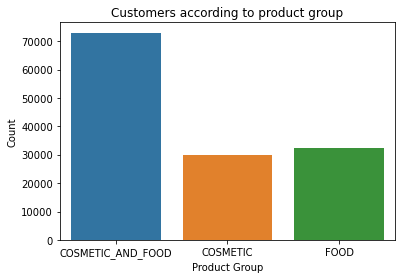

In [60]:
ax = sns.countplot(x='PRODUCT_GROUP', data=customers_clean)
ax.set_title("Customers according to product group")
ax.tick_params(axis='x')
ax.set_xlabel("Product Group")
ax.set_ylabel("Count");

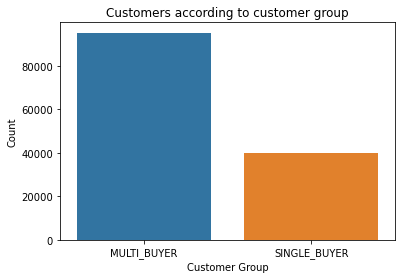

In [61]:
ax = sns.countplot(x='CUSTOMER_GROUP', data=customers_clean)
ax.set_title("Customers according to customer group")
ax.tick_params(axis='x')
ax.set_xlabel("Customer Group")
ax.set_ylabel("Count");

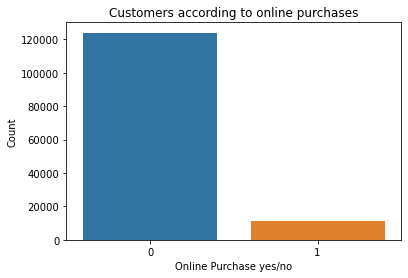

In [62]:
ax = sns.countplot(x='ONLINE_PURCHASE', data=customers_clean)
ax.set_title("Customers according to online purchases")
ax.tick_params(axis='x')
ax.set_xlabel("Online Purchase yes/no")
ax.set_ylabel("Count");

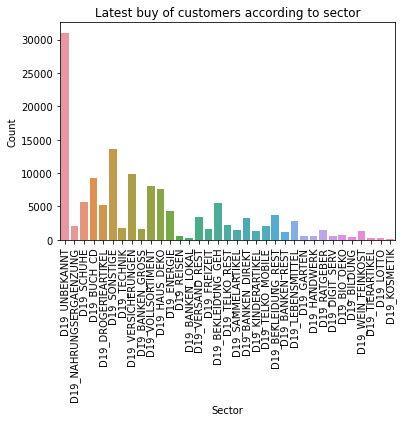

In [63]:
ax = sns.countplot(x='D19_LETZTER_KAUF_BRANCHE', data=customers_clean)
ax.set_title("Latest buy of customers according to sector")
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Sector")
ax.set_ylabel("Count");

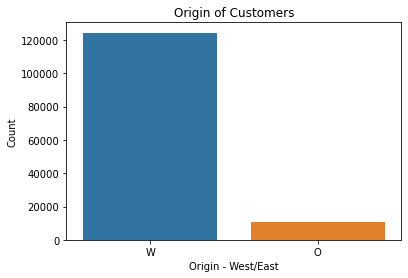

In [64]:
ax = sns.countplot(x='OST_WEST_KZ', data=customers_clean)
ax.set_title("Origin of Customers")
ax.tick_params(axis='x')
ax.set_xlabel("Origin - West/East")
ax.set_ylabel("Count");

<a id='pca'></a>
### Part 1.1: Feature selection with PCA

With PCA selection, variables will be selected according to the magnitude of their coefficents. Each component will be ranked according to the importance through explained variance. Further information can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [65]:
def pca_features(df, n_components = None):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook
    n_components - number of components to keep. Default = None
    
    OUTPUT:
    pca_trans - (array) Projection of X in the first principal components, 
    where n_samples is the number of samples and n_components is the number of the components.
    pca_fit - (array) instance itself
    
    '''
    pca_fit = PCA(n_components).fit(df)
    pca_trans = pca_fit.transform(df)

    return pca_trans, pca_fit

In [66]:
azdias_trans, azdias_fit = pca_features(azdias_new)

In [67]:
azdias_trans.shape

(751331, 355)

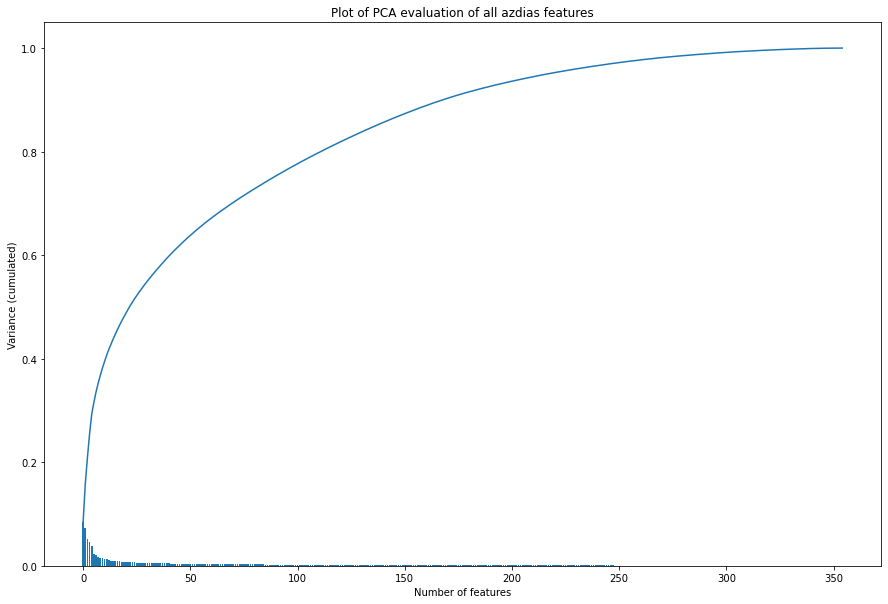

In [68]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.bar(np.arange(len(azdias_fit.explained_variance_ratio_)), azdias_fit.explained_variance_ratio_)
ax.plot(np.cumsum(azdias_fit.explained_variance_ratio_))
 
ax.set_xlabel('Number of features')
ax.set_ylabel('Variance (cumulated)')
plt.title('Plot of PCA evaluation of all azdias features');

In [69]:
n = 10
for i in range(10, 350, n):
    print('variance explained by first {} features: {}%'.format(i, sum(azdias_fit.explained_variance_ratio_[:i]).round(2)*100))

variance explained by first 10 features: 38.0%
variance explained by first 20 features: 48.0%
variance explained by first 30 features: 54.0%
variance explained by first 40 features: 59.0%
variance explained by first 50 features: 63.0%
variance explained by first 60 features: 67.0%
variance explained by first 70 features: 70.0%
variance explained by first 80 features: 73.0%
variance explained by first 90 features: 75.0%
variance explained by first 100 features: 77.0%
variance explained by first 110 features: 80.0%
variance explained by first 120 features: 82.0%
variance explained by first 130 features: 84.0%
variance explained by first 140 features: 85.0%
variance explained by first 150 features: 87.0%
variance explained by first 160 features: 89.0%
variance explained by first 170 features: 90.0%
variance explained by first 180 features: 91.0%
variance explained by first 190 features: 93.0%
variance explained by first 200 features: 94.0%
variance explained by first 210 features: 94.0%
v

> The graph and the detailed analysis shows that the cumulated variance remains fairly stable above 200 features. Therefore, I will refit the PCA with n_components = 200.

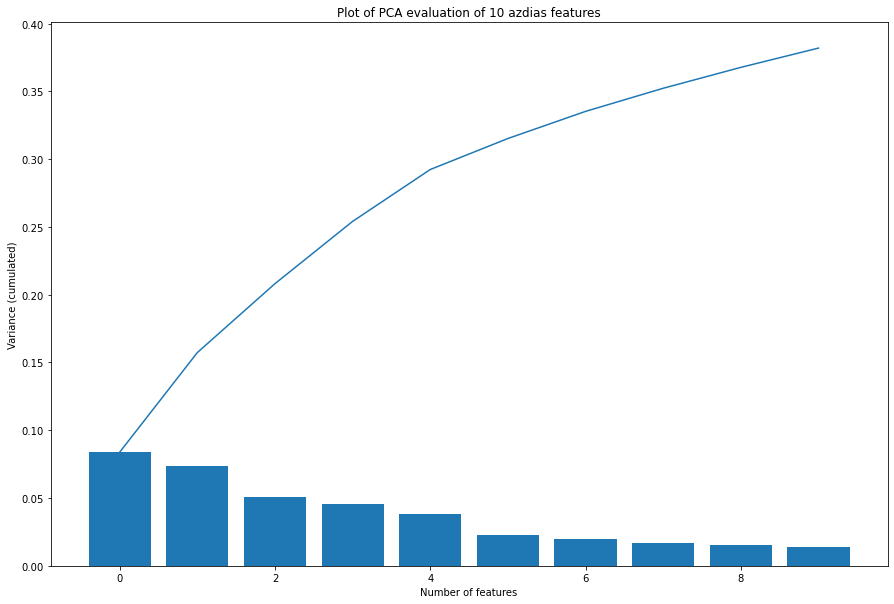

In [70]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.bar(np.arange(len(azdias_fit.explained_variance_ratio_[:10])), azdias_fit.explained_variance_ratio_[:10])
ax.plot(np.cumsum(azdias_fit.explained_variance_ratio_[:10]))
 
ax.set_xlabel('Number of features')
ax.set_ylabel('Variance (cumulated)')
plt.title('Plot of PCA evaluation of 10 azdias features');

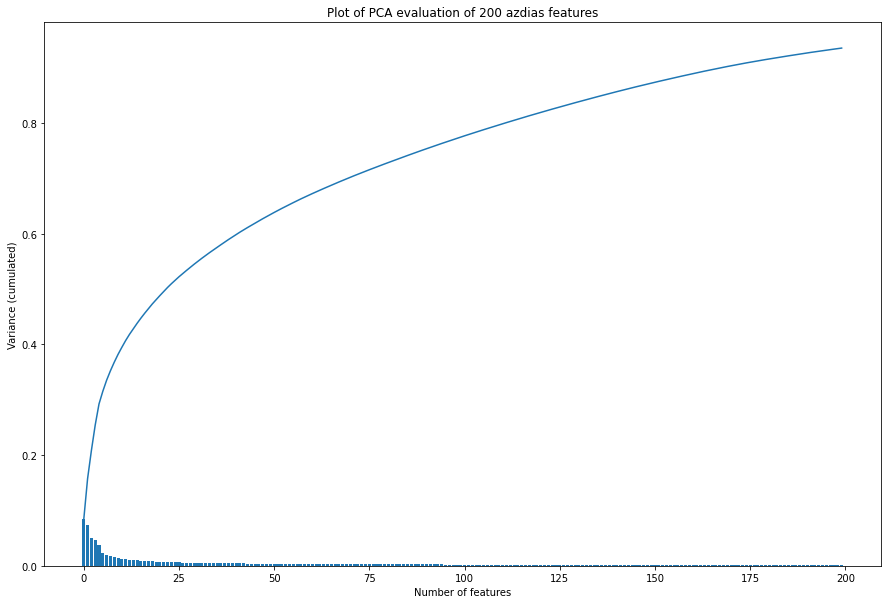

In [71]:
plt.figure(figsize=(15, 10))
ax = plt.subplot()
ax.bar(np.arange(len(azdias_fit.explained_variance_ratio_[:200])), azdias_fit.explained_variance_ratio_[:200])
ax.plot(np.cumsum(azdias_fit.explained_variance_ratio_[:200]))
 
ax.set_xlabel('Number of features')
ax.set_ylabel('Variance (cumulated)')
plt.title('Plot of PCA evaluation of 200 azdias features');

> For further analysis, I will reduce the features down to 200

In [72]:
azdias_trans_200, azdias_fit_200 = pca_features(azdias_new, 200)

In [73]:
def show_top_bottom_features(df, pca_fit, i):
    '''
    INPUT:
    df - (pandas dataframe) Dataframe where pca fit has been performed
    pca_fit - array, output of pca_features
    i - location of component
        
    OUTPUT:
    features_list - list of top_5 positive and negative features impacting component i
    
    '''
    feature_values = pca_fit.components_[i]
    five_positive = sorted(feature_values, reverse = True)[:5]
    five_negative = sorted(feature_values, reverse = False)[:5]
    
    features_list = {}
    for i in five_positive:
        idx = np.where(feature_values==i)
        features = df.columns[idx][0]
        features_list[features] = i
        
    for i in five_negative:
        idx = np.where(feature_values==i)
        features = df.columns[idx][0]
        features_list[features] = i
    
    return features_list


In [74]:
show_top_bottom_features(azdias_new, azdias_fit_200, 0)

{'PLZ8_ANTG3': 0.1264479024256429,
 'KBA13_ANTG3': 0.12580722927383425,
 'KBA13_ANTG4': 0.12312368456287924,
 'KBA13_BAUMAX': 0.12255329545395266,
 'PLZ8_ANTG4': 0.12219801134259825,
 'MOBI_REGIO': -0.13474767443094887,
 'PLZ8_ANTG1': -0.12766781742387903,
 'KBA13_ANTG1': -0.12716165238145286,
 'LP_STATUS_FEIN': -0.12468260588970709,
 'KBA05_ANTG1': -0.12373097671208164}

In [75]:
show_top_bottom_features(azdias_new, azdias_fit_200, 1)

{'KBA05_SEG6': 0.18141843528105178,
 'KBA05_KRSOBER': 0.16514650452579002,
 'KBA05_KRSVAN': 0.1627186457166623,
 'KBA05_KRSZUL': 0.16105615475646098,
 'KBA05_SEG8': 0.1545526768664473,
 'FINANZ_SPARER': -0.0377196332197064,
 'KBA05_ANTG3': -0.03557531347939269,
 'CJT_TYP_2': -0.03499773237894701,
 'PRAEGENDE_JUGENDJAHRE': -0.03484276757305378,
 'CJT_TYP_1': -0.03326744423038237}

In [76]:
show_top_bottom_features(azdias_new, azdias_fit_200, 2)

{'ONLINE_AFFINITAET': 0.15711511229842365,
 'D19_GESAMT_ANZ_24': 0.14605138158939968,
 'CJT_TYP_2': 0.1428909955434221,
 'PRAEGENDE_JUGENDJAHRE': 0.14215874959167168,
 'D19_GESAMT_ANZ_12': 0.1380322878530286,
 'D19_GESAMT_ONLINE_DATUM': -0.14208144381963161,
 'D19_VERSAND_ONLINE_DATUM': -0.13711018943702102,
 'D19_GESAMT_DATUM': -0.1347205436196252,
 'CJT_TYP_5': -0.13434661108437548,
 'D19_VERSAND_DATUM': -0.1331357687120806}

In [77]:
show_top_bottom_features(azdias_new, azdias_fit_200, 3)

{'KBA13_SITZE_5': 0.16360923316458878,
 'KBA13_SEG_KLEINWAGEN': 0.14318441174295626,
 'KBA13_KMH_140_210': 0.14224988815786338,
 'KBA13_HALTER_25': 0.1332438118942537,
 'KBA13_KMH_180': 0.13109688392838173,
 'KBA13_HERST_BMW_BENZ': -0.1975882225661728,
 'KBA13_MERCEDES': -0.17021674167032627,
 'KBA13_SEG_OBEREMITTELKLASSE': -0.1687312807803891,
 'KBA13_BMW': -0.16397516202233545,
 'KBA13_SITZE_4': -0.156674650575969}

In [78]:
show_top_bottom_features(azdias_new, azdias_fit_200, 4)

{'FINANZ_VORSORGER': 0.14995829667147031,
 'ALTERSKATEGORIE_GROB': 0.1443528398386303,
 'CJT_TYP_5': 0.1391884093151123,
 'CJT_TYP_3': 0.12619903044390618,
 'CJT_TYP_4': 0.12429107989647346,
 'FINANZ_SPARER': -0.15982746243886803,
 'CJT_TYP_1': -0.15670607248617105,
 'FINANZ_ANLEGER': -0.1565586892049381,
 'FINANZ_UNAUFFAELLIGER': -0.15554278355798995,
 'RT_KEIN_ANREIZ': -0.14762830976069027}

In [79]:
customers_trans, customers_fit = pca_features(customers_new)

In [80]:
n = 10
for i in range(10, 350, n):
    print('variance explained by first {} features: {}%'.format(i, sum(customers_fit.explained_variance_ratio_[:i]).round(2)*100))

variance explained by first 10 features: 33.0%
variance explained by first 20 features: 43.0%
variance explained by first 30 features: 50.0%
variance explained by first 40 features: 55.00000000000001%
variance explained by first 50 features: 60.0%
variance explained by first 60 features: 63.0%
variance explained by first 70 features: 67.0%
variance explained by first 80 features: 70.0%
variance explained by first 90 features: 72.0%
variance explained by first 100 features: 75.0%
variance explained by first 110 features: 77.0%
variance explained by first 120 features: 80.0%
variance explained by first 130 features: 82.0%
variance explained by first 140 features: 84.0%
variance explained by first 150 features: 86.0%
variance explained by first 160 features: 87.0%
variance explained by first 170 features: 89.0%
variance explained by first 180 features: 90.0%
variance explained by first 190 features: 91.0%
variance explained by first 200 features: 93.0%
variance explained by first 210 feat

In [81]:
show_top_bottom_features(customers_new, customers_fit, 0)

{'KBA13_ANTG3': 0.140601149272327,
 'PLZ8_ANTG3': 0.13943751119542655,
 'KBA13_BAUMAX': 0.13368344263466006,
 'KBA13_ANTG4': 0.1322879577507552,
 'PLZ8_BAUMAX': 0.13070751441559436,
 'MOBI_REGIO': -0.14370961098429536,
 'PLZ8_ANTG1': -0.13408625075889546,
 'KBA13_ANTG1': -0.13401522953094722,
 'MOBI_RASTER': -0.13099062168287007,
 'KBA13_AUTOQUOTE': -0.12805888149992178}

In [82]:
customers_trans_200, customers_fit_200 = pca_features(customers_new, 200)

<a id='kmean'></a>
### Part 1.2: K-Mean Clustering
In this part, I will use K-Mean clustering on the PCA reduced dataset in order to find clusters in the adzias and cutomers dataset. This will help regading the question: what describes a customer and what describes a general person in Germany.

In [83]:
def KMean_scores(data, k_start, k_end, step=1):
    '''
    INPUT:
    data - data to fit
    k_start - number of clusters to begin with
    k_end - maximum number of clusters
    step - defined steps in cluster
        
    OUTPUT:
    scores - model score received for each trained model cluster
    
    '''    
    scores = []
    
    for n in range(k_start, k_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        kmeans = KMeans(n, random_state=42)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, range(k_start, k_end+1, step)

In [84]:
scores, range_ = KMean_scores(azdias_trans_200, 2, 15, 1)


Training for n_clusters:  2
Score:  233456458.14030665
Time elapsed: 21.24 sec.

Training for n_clusters:  3
Score:  214672780.5027608
Time elapsed: 31.99 sec.

Training for n_clusters:  4
Score:  206840799.88835377
Time elapsed: 38.10 sec.

Training for n_clusters:  5
Score:  202787546.16949493
Time elapsed: 52.50 sec.

Training for n_clusters:  6
Score:  199191771.6586181
Time elapsed: 138.27 sec.

Training for n_clusters:  7
Score:  196472766.2247985
Time elapsed: 91.90 sec.

Training for n_clusters:  8
Score:  194172942.65174508
Time elapsed: 95.33 sec.

Training for n_clusters:  9
Score:  192122542.6212899
Time elapsed: 104.55 sec.

Training for n_clusters:  10
Score:  190668187.82939148
Time elapsed: 157.01 sec.

Training for n_clusters:  11
Score:  189098466.42799062
Time elapsed: 194.88 sec.

Training for n_clusters:  12
Score:  187940070.66637486
Time elapsed: 208.89 sec.

Training for n_clusters:  13
Score:  186759985.90473008
Time elapsed: 334.38 sec.

Training for n_cluste

> I am using the elbow method to determine the optimal number of clusters for the KMean clustering. In the elbow method the "elbow" of the curve between number of cluster and sum of squared distances is taken.

In [85]:
def plot_elbow(scores, range_):
    
    fig = plt.figure(figsize=(15,10))
    
    ax = fig.add_subplot(111)
    ax.plot(range_, scores, linestyle='--', marker='o', color='b')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances according to numbers of features")
    
    plt.show()

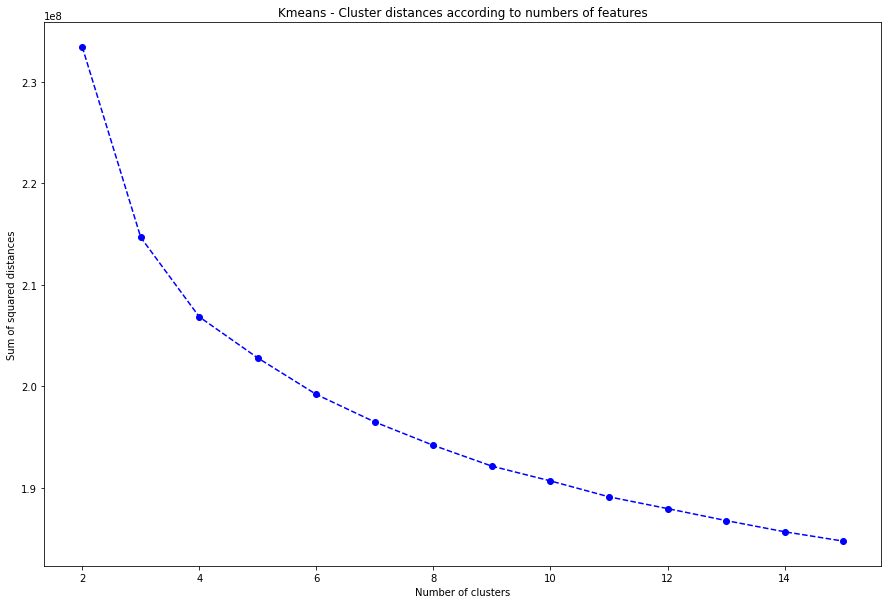

In [86]:
plot_elbow(scores, range_)

> According to the elbow method, I decided to take 9 clusters for the KMeans.

In [107]:
kmeans = KMeans(9, random_state=42)
model = kmeans.fit(customers_trans_200)

In [108]:
azdias_cluster = model.predict(azdias_trans_200)
customer_cluster = model.predict(customers_trans_200)

In [109]:
azdias_cluster = pd.Series(azdias_cluster)
customer_cluster = pd.Series(customer_cluster)

> The KMeans results are stored in a comparison dataframe where further analysis will be based on.

In [110]:
df_comparison = pd.DataFrame([])

df_comparison['general'] = azdias_cluster.value_counts().sort_index()
df_comparison['customers'] = customer_cluster.value_counts().sort_index()
df_comparison['general_percentage'] = df_comparison['general'] / len(azdias_cluster)*100
df_comparison['customer_percentage'] = df_comparison['customers'] / len(customer_cluster)*100
df_comparison['diff_percentage'] = df_comparison['customer_percentage'] - df_comparison['general_percentage']
df_comparison.reset_index(inplace=True)
df_comparison.rename(columns={"index":"cluster"}, inplace=True)

In [111]:
df_comparison

,cluster,general,customers,general_percentage,customer_percentage,diff_percentage
0,0,174774,22680,23.261918,16.782099,-6.479819
1,1,164087,17612,21.839509,13.032025,-8.807484
2,2,119591,19774,15.917219,14.631800,-1.285419
3,3,24671,16049,3.283639,11.875481,8.591842
4,4,83381,29012,11.097772,21.467472,10.369700
5,6,32053,7309,4.266162,5.408305,1.142143
6,7,97161,11152,12.931850,8.251939,-4.679912
7,8,55613,10658,7.401931,7.886403,0.484472


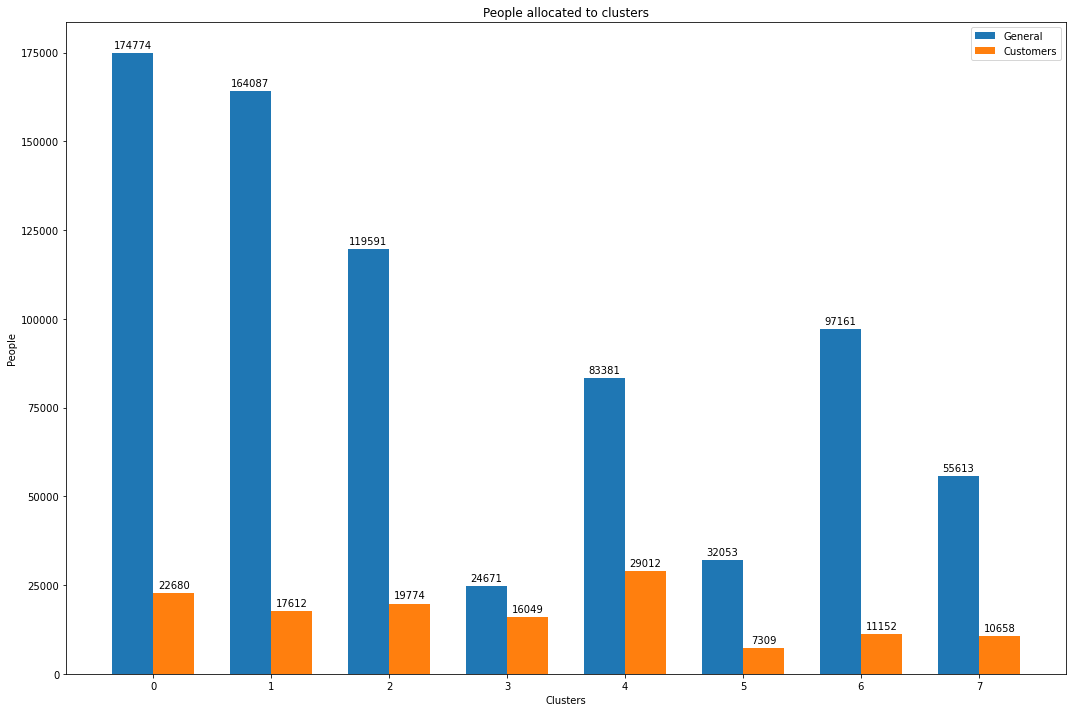

In [112]:
x = np.arange(len(df_comparison['cluster']))
width = 0.35 

fig = plt.figure(figsize=(15,10))
    
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, df_comparison['general'], width, label='General')
rects2 = ax.bar(x + width/2, df_comparison['customers'], width, label='Customers')


ax.set_ylabel('People')
ax.set_xlabel('Clusters')
ax.set_title('People allocated to clusters')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

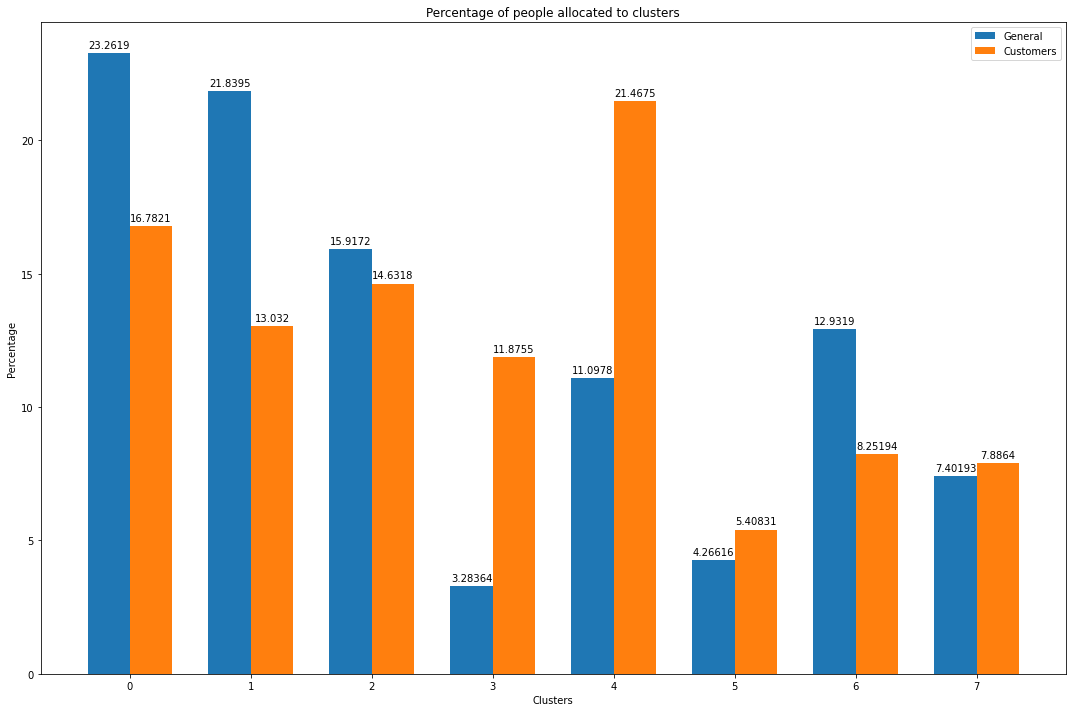

In [113]:
x = np.arange(len(df_comparison['cluster']))
width = 0.35 

fig = plt.figure(figsize=(15,10))
    
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, df_comparison['general_percentage'], width, label='General')
rects2 = ax.bar(x + width/2, df_comparison['customer_percentage'], width, label='Customers')


ax.set_ylabel('Percentage')
ax.set_xlabel('Clusters')
ax.set_title('Percentage of people allocated to clusters')

ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

> The highest percentage of customers are allocated to cluster 4 and 1 indicating that the features in the pca component influencing these clusters will give us the characteristic of the cluster and therefore, the customer.

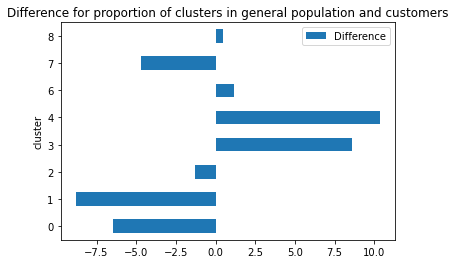

In [114]:
df_comparison.plot.barh(x='cluster', y='diff_percentage', label='Difference', title='Difference for proportion of clusters in general population and customers')

plt.show()

In [115]:
location = model.cluster_centers_
location.shape

(9, 200)

In [116]:
centers = azdias_fit_200.inverse_transform(location)

In [117]:
df_centers = pd.DataFrame(centers, columns=azdias_new.columns)
df_centers

,CAMEO_DEUG_2015,OST_WEST_KZ,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_G

In [118]:
show_top_bottom_features(df_centers, azdias_fit_200, 4)

{'FINANZ_VORSORGER': 0.14995829667147031,
 'ALTERSKATEGORIE_GROB': 0.1443528398386303,
 'CJT_TYP_5': 0.1391884093151123,
 'CJT_TYP_3': 0.12619903044390618,
 'CJT_TYP_4': 0.12429107989647346,
 'FINANZ_SPARER': -0.15982746243886803,
 'CJT_TYP_1': -0.15670607248617105,
 'FINANZ_ANLEGER': -0.1565586892049381,
 'FINANZ_UNAUFFAELLIGER': -0.15554278355798995,
 'RT_KEIN_ANREIZ': -0.14762830976069027}

In [119]:
show_top_bottom_features(df_centers, azdias_fit_200, 1)

{'KBA05_SEG6': 0.18141843528105178,
 'KBA05_KRSOBER': 0.16514650452579002,
 'KBA05_KRSVAN': 0.1627186457166623,
 'KBA05_KRSZUL': 0.16105615475646098,
 'KBA05_SEG8': 0.1545526768664473,
 'FINANZ_SPARER': -0.0377196332197064,
 'KBA05_ANTG3': -0.03557531347939269,
 'CJT_TYP_2': -0.03499773237894701,
 'PRAEGENDE_JUGENDJAHRE': -0.03484276757305378,
 'CJT_TYP_1': -0.03326744423038237}

In [120]:
show_top_bottom_features(df_centers, azdias_fit_200, 2)

{'ONLINE_AFFINITAET': 0.15711511229842365,
 'D19_GESAMT_ANZ_24': 0.14605138158939968,
 'CJT_TYP_2': 0.1428909955434221,
 'PRAEGENDE_JUGENDJAHRE': 0.14215874959167168,
 'D19_GESAMT_ANZ_12': 0.1380322878530286,
 'D19_GESAMT_ONLINE_DATUM': -0.14208144381963161,
 'D19_VERSAND_ONLINE_DATUM': -0.13711018943702102,
 'D19_GESAMT_DATUM': -0.1347205436196252,
 'CJT_TYP_5': -0.13434661108437548,
 'D19_VERSAND_DATUM': -0.1331357687120806}

> Cluster 4 has the highest share of customers. The top features of the cluster indicates that the customers have a financial typology of being prepared, are advertise-(and cross channel) interested store and online shoppers. With the second highest share in cluster 1, customers tend to drive upperclass cars like BMW 7 series, vans or new cars.

For comparison, I will also look at a supervised model for feature selection to validate the unsupervised results.

In [121]:
df = customers_new.copy()
df['customer'] = 1
df.shape

(135144, 356)

In [122]:
df = df.append(azdias_new, ignore_index = True)
df.shape

(886475, 356)

In [123]:
df['customer'].fillna(0, inplace = True)
df['customer'].value_counts()

0.0    751331
1.0    135144
Name: customer, dtype: int64

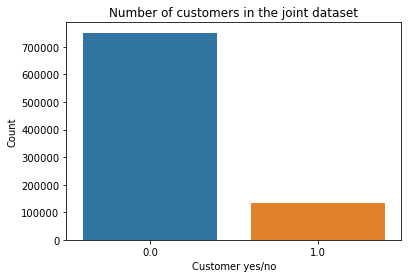

In [124]:
ax = sns.countplot(x='customer', data=df)
ax.set_title("Number of customers in the joint dataset")
ax.set_xlabel("Customer yes/no")
ax.set_ylabel("Count");

In [125]:
y = df['customer']
X = df.drop(columns = 'customer')

In [126]:
rfc = RandomForestClassifier(random_state=42, class_weight = 'balanced')
rfc_model_df = rfc.fit(X, y)

In [127]:
start_time = time.time()
importances = rfc_model_df.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model_df.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.036 seconds


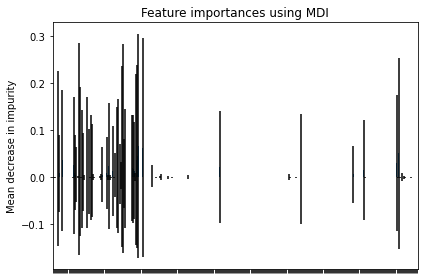

In [128]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels([])
fig.tight_layout()

In [129]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X,y)
selected_feat= X.columns[(sel.get_support())]
len(selected_feat)

45

In [130]:
print(selected_feat)

Index(['ANZ_HH_TITEL', 'ANZ_TITEL', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_REST',
       'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE',
       'D19_FREIZEIT', 'D19_GARTEN', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_NAHRUNGSERGAENZUNG', 'D19_REISEN', 'D19_SCHUHE',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_TIERARTIKEL', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM',
       'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_WEIN_FEINKOST',
       'DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6',
       'KBA05_SEG7', 'KBA13_KMH_251', 'KBA13_KRSSEG_KLEIN', 'SOHO_KZ',
       'TITEL_KZ', 'UNGLEICHENN_FLAG'],
 

> The selected features chosen by the supervised learning model are different from the features of the unsupervised learning model.

<a id='model'></a>
## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [131]:
mailout_train = data_load_and_clean('Udacity_MAILOUT_052018_TRAIN.csv')

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/2206608064.py:1: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  mailout_train = data_load_and_clean('Udacity_MAILOUT_052018_TRAIN.csv')


Filling NaNs...
Splitting of CAMEO_INTL_2015 into _WEALTH and _FAMILY...
Dropping columns with more than 30% NaN's...
Dropped columns: /n1          AGER_TYP
3          ALTER_HH
4       ALTER_KIND1
5       ALTER_KIND2
6       ALTER_KIND3
7       ALTER_KIND4
99        EXTSEL992
299    KK_KUNDENTYP
Name: column_name, dtype: object
Dropping columns with more than 50 missing features...
Total rows removed: 8748
Correcting dtypes...
Finished: Dataset loaded and cleaned!


In [132]:
mailout_train.to_csv('CLEAN_Udacity_MAILOUT_052018_TRAIN.csv', index = False)

In [133]:
mailout_train = pd.read_csv('CLEAN_Udacity_MAILOUT_052018_TRAIN.csv')

In [134]:
mailout_train.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13

In [135]:
mailout_train_new = prepare_columns(mailout_train)

In [136]:
mailout_train_scale = perform_scaling(mailout_train_new)

original shape:    (34214, 356)
scaled shape: (34214, 356)


In [137]:
mailout_train_new['RESPONSE'].value_counts()

0    33790
1      424
Name: RESPONSE, dtype: Int64

In [138]:
mailout_train_new['RESPONSE'].value_counts()[0]/len(mailout_train_new)

0.9876074121704566

In [139]:
mailout_train_scale['RESPONSE'].value_counts()

-0.112018    33790
 8.927116      424
Name: RESPONSE, dtype: int64

### Part 2.1: Logistic Regression Model
First, I will try out a locgistc regression model on the unscaled and scaled data for a first reference.

In [140]:
response = mailout_train_new['RESPONSE'].astype(int)
attributes = mailout_train_new.drop(columns = 'RESPONSE')

In [141]:
X_train, X_test, y_train, y_test = train_test_split(attributes, response, stratify=response, test_size=0.3, random_state=42)

In [142]:
lrm = LogisticRegression(random_state=42, class_weight = 'balanced')

In [143]:
lrm_model = lrm.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [144]:
lrm_pred = lrm_model.predict_proba(X_test)

In [145]:
lrm_model.score(X_test, y_test)

0.6696541646371165

In [146]:
roc_score_lrm = roc_auc_score(y_test, lrm_model.predict_proba(X_test)[:,1])
roc_score_lrm

0.6829423250481933

> The logistic regression model reached a precision score of 67% and a ROC-score of 68.3%.

In [147]:
response_sc = mailout_train_scale['RESPONSE'].astype(int)
attributes_sc = mailout_train_scale.drop(columns = 'RESPONSE')

In [148]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(attributes_sc, response_sc, stratify=response, test_size=0.3, random_state=42)

In [149]:
lrm_model_sc = lrm.fit(X_train_sc, y_train_sc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [150]:
lrm_pred_sc = lrm_model_sc.predict_proba(X_test_sc)

In [151]:
lrm_model_sc.score(X_test_sc, y_test_sc)

0.7680467608377983

In [152]:
roc_score_lrm_sc = roc_auc_score(y_test_sc, lrm_model_sc.predict_proba(X_test_sc)[:,1])
roc_score_lrm_sc

0.6432670097535894

> The result upon the scaled data raised to 76.8% but the ROC score dropped down to 64%.

<a id='clf'></a>
### Part 2.2: Decision Tree Model
Next, I want to see if a Decision Tree raises the model precision.

In [153]:
clf = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')
clf_model = clf.fit(X_train_sc,y_train_sc)

In [154]:
clf.pred = clf_model.predict_proba(X_test_sc)
clf_model.score(X_test_sc, y_test_sc)

0.9768144179249878

In [155]:
roc_score_clf = roc_auc_score(y_test_sc, clf_model.predict_proba(X_test_sc)[:,1])
roc_score_clf

0.5178516783350394

> With a Decision Tree Classifier, I can reach a model score of 97.7% which is higher than the logistic regression model but the ROC score drops even further down to 51.7%.

<a id='rfc'></a>
### Part 2.3: RFC-Model
As a next step, I will try a Random Forest Classifier to predict the Mail responses.

In [156]:
rfc = RandomForestClassifier(random_state=42, class_weight = 'balanced')
rfc_model = rfc.fit(X_train_sc, y_train_sc)

In [157]:
rfc_pred = rfc_model.predict_proba(X_test_sc)

In [158]:
rfc_pred

array([[0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.95, 0.05]])

In [159]:
rfc_model.score(X_test_sc, y_test_sc)

0.9876278616658548

In [160]:
roc_score_rfc = roc_auc_score(y_test_sc, rfc_model.predict_proba(X_test_sc)[:,1])
roc_score_rfc

0.6912602153276906

> The Random Forest Classifier predicts 98.8% of the test-data correctly and reaches a ROC score of 69% which is the highest so far.

<a id='gbc'></a>
### Part 2.4: Gradient Boosting Classifier
My last model will be the Gradient Boosting Classifier

In [161]:
gbc = GradientBoostingClassifier(random_state = 42)

In [162]:
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = 0.5
sample_weights[y_train == 1] = 40.3

In [177]:
sample_weights.shape

(23949,)

In [165]:
gbc_model = gbc.fit(X_train, y_train, sample_weight = sample_weights)

In [166]:
gbc_pred = gbc_model.predict_proba(X_test)

In [167]:
gbc_pred

array([[0.87049654, 0.12950346],
       [0.56033439, 0.43966561],
       [0.84226073, 0.15773927],
       ...,
       [0.64891739, 0.35108261],
       [0.89682781, 0.10317219],
       [0.51595644, 0.48404356]])

In [168]:
gbc_model.score(X_test, y_test)

0.8106186069167073

In [171]:
roc_score_gbc = roc_auc_score(y_test, gbc_model.predict_proba(X_test)[:,1])
roc_score_gbc

0.782205563227461

In [173]:
gbc_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

> The Gradient Boost classifier predicts 81% of the test-data correctly and reaches a ROC score of 78%.
> Taking all Models into consideration, the Gradient Boost Classifier will be chosed for the supervised learning model.

<a id='gridsearch'></a>
### Part 2.5: GridSearchCV to optimize the Gradient Boost Classifier

In [180]:
parameters = {'learning_rate': [0.1, 0.2], 'max_depth': [2, 3], 'n_estimators': [100]}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid=parameters, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train, sample_weight = sample_weights)
best_model = grid.best_estimator_
print('ROC_AUC score for {} is {}'.format(best_model, grid.best_score_))
print('Best Parameters: {}'.format(grid.best_params_))

ROC_AUC score for GradientBoostingClassifier(max_depth=2) is 0.7763913892155176
Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [181]:
gbc_new = GradientBoostingClassifier(random_state = 42, learning_rate = 0.1, n_estimators = 100, max_depth = 2)

In [182]:
final_model = gbc.fit(X_train, y_train, sample_weight = sample_weights)

<a id='kaeggle'></a>
## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [183]:
mailout_test = data_load_and_clean('Udacity_MAILOUT_052018_TEST.csv')

C:\Users\q407073\AppData\Local\Temp/ipykernel_15904/3894117035.py:1: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  mailout_test = data_load_and_clean('Udacity_MAILOUT_052018_TEST.csv')


Filling NaNs...
Splitting of CAMEO_INTL_2015 into _WEALTH and _FAMILY...
Dropping columns with more than 30% NaN's...
Dropped columns: /n1          AGER_TYP
3          ALTER_HH
4       ALTER_KIND1
5       ALTER_KIND2
6       ALTER_KIND3
7       ALTER_KIND4
99        EXTSEL992
299    KK_KUNDENTYP
Name: column_name, dtype: object
Dropping columns with more than 50 missing features...
Total rows removed: 8656
Correcting dtypes...
Finished: Dataset loaded and cleaned!


In [184]:
mailout_test.to_csv('CLEAN_Udacity_MAILOUT_052018_TEST.csv', index = False)

In [185]:
mailout_test = pd.read_csv('CLEAN_Udacity_MAILOUT_052018_TEST.csv')

In [186]:
mailout_test.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13

In [187]:
LNRs = mailout_test['LNR']

In [188]:
mailout_test_new = prepare_columns(mailout_test)

In [189]:
mailout_test_new.head()

,CAMEO_DEUG_2015,OST_WEST_KZ,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_G

In [190]:
pred = final_model.predict_proba(mailout_test_new)

In [191]:
kaeggle_rfc = pd.DataFrame(index=LNRs, data=pred, columns=['Probability_no_response','Probability_response' ])

In [192]:
kaeggle_rfc['Probability_response'].value_counts()

0.637698    1
0.421884    1
0.116939    1
0.194793    1
0.755010    1
0.674102    1
0.225953    1
0.123873    1
0.279685    1
0.090766    1
0.695168    1
0.027317    1
0.618126    1
0.602362    1
0.569658    1
0.604629    1
0.662097    1
0.096872    1
0.523682    1
0.054807    1
0.177867    1
0.067811    1
0.078795    1
0.107988    1
0.421514    1
0.654441    1
0.070220    1
0.496131    1
0.619823    1
0.115439    1
0.126933    1
0.032577    1
0.262086    1
0.069876    1
0.049020    1
0.039620    1
0.512584    1
0.046080    1
0.150721    1
0.017760    1
0.128431    1
0.172315    1
0.349797    1
0.058880    1
0.054839    1
0.791817    1
0.477932    1
0.041254    1
0.093030    1
0.088088    1
0.042192    1
0.474829    1
0.615539    1
0.697159    1
0.571101    1
0.262412    1
0.207271    1
0.573046    1
0.162269    1
0.051521    1
0.732330    1
0.391977    1
0.649164    1
0.101881    1
0.070111    1
0.186898    1
0.512153    1
0.118512    1
0.074826    1
0.123186    1
0.220813    1
0.8118

In [193]:
kaeggle_rfc.columns

Index(['Probability_no_response', 'Probability_response'], dtype='object')

In [194]:
kaeggle_rfc.drop(columns = ['Probability_no_response'], inplace = True)
kaeggle_rfc.head()

,Probability_response
LNR,
1754,0.637698
1770,0.611335
1465,0.108004
1470,0.063747
1478,0.129395


In [195]:
kaeggle_rfc.rename(columns={'Probability_response': "RESPONSE"}, inplace=True)
kaeggle_rfc.head()

,RESPONSE
LNR,
1754,0.637698
1770,0.611335
1465,0.108004
1470,0.063747
1478,0.129395


In [196]:
kaeggle_rfc.to_csv('UDACITY_Kaeggle_competition.csv', index = False)